# Medical Abbreviation Disambiguation Model

## Project Overview

This code implements a transformer-based model to disambiguate medical abbreviations based on their context. The model predicts the full expansion of medical abbreviations like CABG, ECG, ER, and MRI by analyzing the surrounding text.

## Requirements

- Python 3.8 or higher
- PyTorch 1.8.0 or higher
- spaCy 3.0 or higher with `en_core_web_sm` model
- NumPy, Pandas, Matplotlib, scikit-learn
- GloVe word embeddings (specifically `glove.6B.100d.txt`)

## Installation

```bash
# Install required packages
pip install torch numpy pandas matplotlib spacy scikit-learn

# Download spaCy model
python -m spacy download en_core_web_sm

# Download GloVe embeddings
# From https://nlp.stanford.edu/projects/glove/
wget https://nlp.stanford.edu/data/glove.6B.zip
unzip glove.6B.zip
```

## Data Format

The model expects a CSV file named `train.csv` with these columns:
- `TEXT`: The full medical text
- `LABEL`: The expanded form of the abbreviation
- `LOCATION`: The word position (index) of the abbreviation in the text

## Running the Code

1. Ensure your dataset `train.csv` is in the working directory
2. Place the GloVe embeddings file `glove.6B.100d.txt` in the working directory
3. Run the script to train and evaluate the model

```bash
python medical_abbrev_model.py
```

## Model Architecture

- Input: Context window around medical abbreviations
- Embedding: 100-dimensional GloVe word embeddings
- Encoder: 2-layer transformer with 4 attention heads
- Pooling: Mean pooling across token dimension
- Classifier: Two-layer MLP (100→50→num_classes)
- Output: Probability distribution over possible expansions

## Key Parameters

- `MAX_LEN`: 256 (maximum sequence length)
- `EMB_DIM`: 100 (embedding dimension)
- `BATCH`: 64 (batch size)
- `EPOCHS`: 20 (training epochs)
- `n_heads`: 4 (number of attention heads)
- `nlayers`: 2 (number of transformer layers)
- `hid_dim`: 256 (hidden dimension in feed-forward layers)

## Model Output

The model saves:
- Trained model weights and configuration to `checkpoints/transformer_checkpoint.pth`
- Performance visualizations for loss, accuracy, precision, recall, and F1 score
- Confusion matrix for the top 50 classes

## Inference Function

After training, use the `predict()` function for inference:

```python
# Example usage
expanded = predict("The patient was diagnosed with acute MI and sent to the ICU.", 6)
print("MI expands to:", expanded)
```

## Performance Considerations

- The model is designed to be lightweight (2 layers, 4 heads) for efficient training
- Pre-trained GloVe embeddings provide strong lexical priors
- 80/20 train/validation split ensures all classes appear in both sets
- Works well for common medical abbreviations but may struggle with rare ones

After filtering: 3000000 samples, 22555 unique labels
Number of classes: 22555
Loaded tokenized_texts.pkl
Vocab size: 489792
Train: 2400000, Val: 600000

Overall label distribution:
interstitial fibrosis       268
soluble guanylyl cyclase    268
intrauterine pregnancy      268
childhoodonset              268
keratan sulfate             268
anticoagulation             268
atrial septal defects       268
schistosoma mansoni         268
achilles tendon             268
high glucose                268
Name: LABEL, dtype: int64


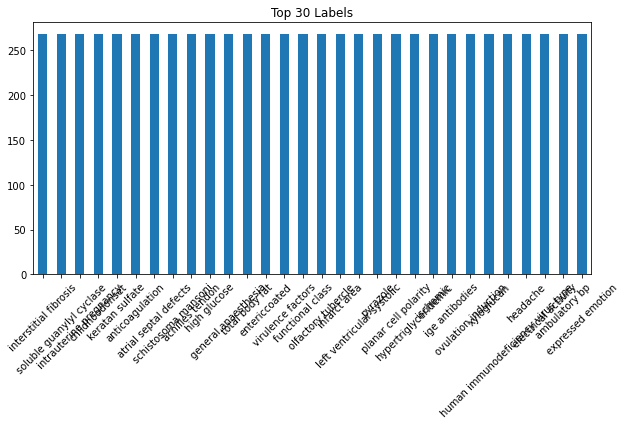

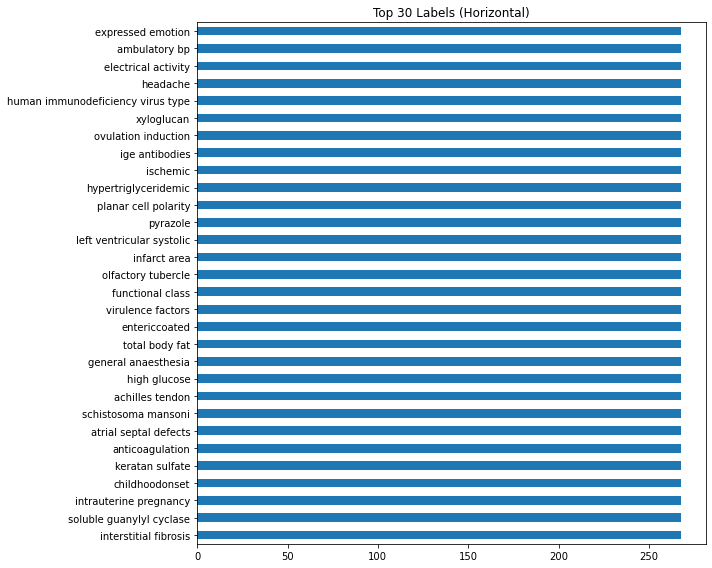

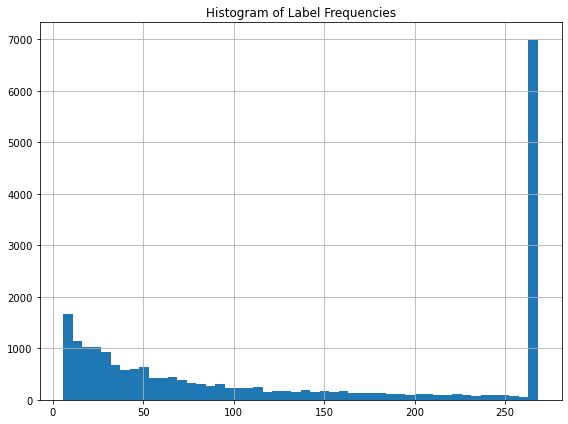

TransformerClassifier(
  (embedding): Embedding(489792, 100, padding_idx=0)
  (pos_enc): PositionalEncoding()
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=100, out_features=100, bias=True)
        )
        (linear1): Linear(in_features=100, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=256, out_features=100, bias=True)
        (norm1): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (classifier): Sequential(
    (0): Linear(in_features=100, out_features=50, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=50, out_f

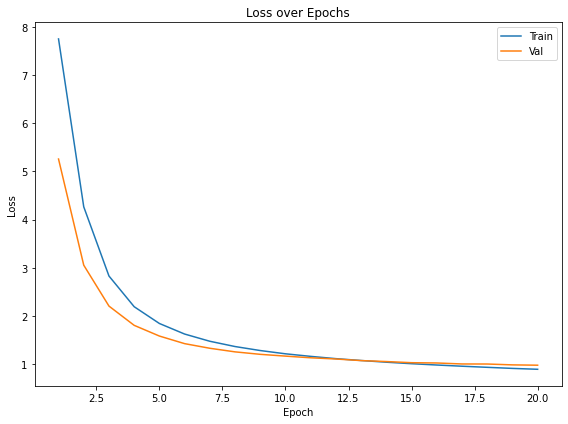

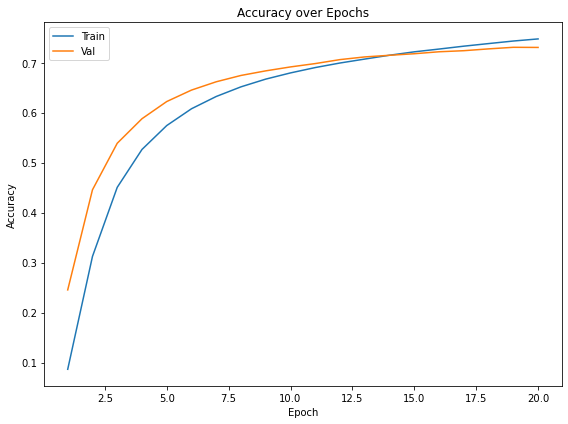

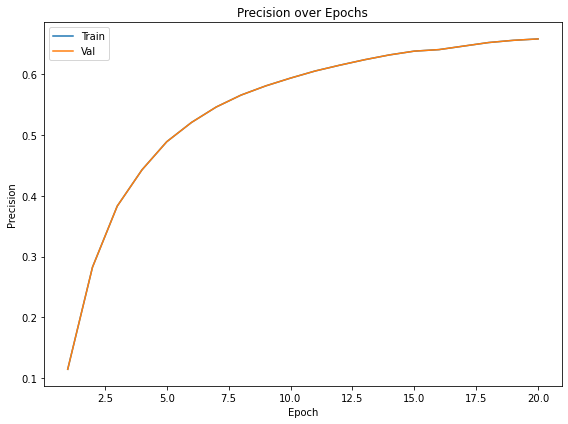

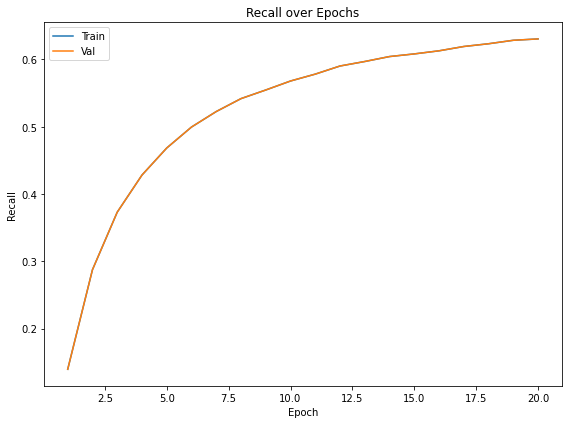

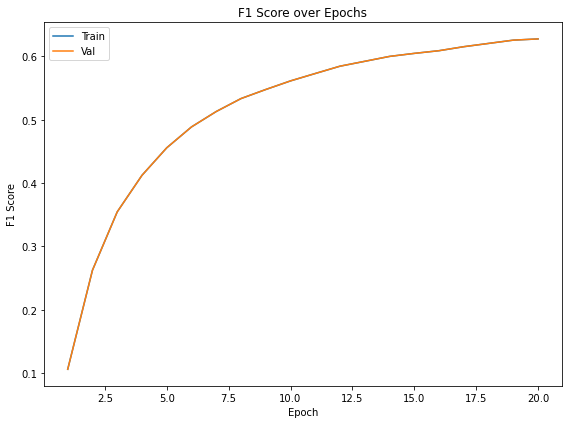

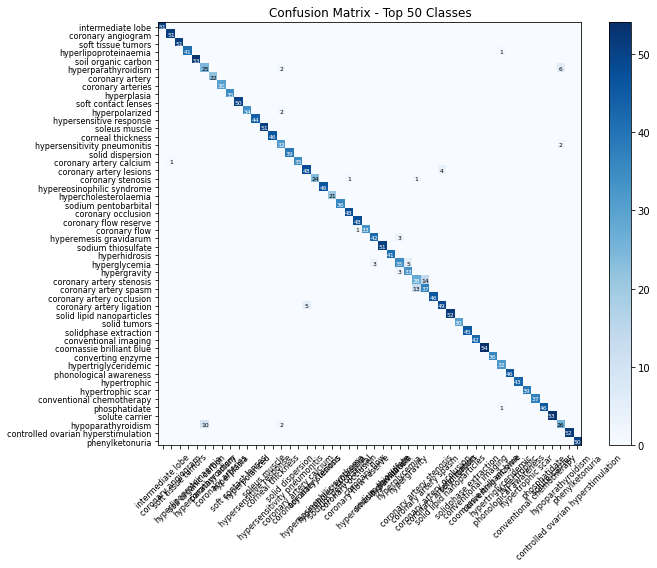

Predicted expansion: meconium ileus


In [1]:
import os
import zipfile
import random
import pickle
from collections import Counter

import numpy as np
import pandas as pd
import spacy
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# -------------------------------
# 0. Reproducibility
# -------------------------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# -------------------------------
# 1. Load & Preprocess Dataset
# -------------------------------
# Unzip if needed
for z in ("train.csv.zip", "archive (3).zip"):
    if os.path.exists(z) and not os.path.exists("train.csv"):
        zipfile.ZipFile(z).extractall(".")

df = pd.read_csv("train.csv")
# Keep necessary columns and drop NaNs
df = df.dropna(subset=["TEXT","LABEL","LOCATION"])
df["LOCATION"] = df["LOCATION"].astype(int)

# Filter out labels with fewer than 5 occurrences
vc = df["LABEL"].value_counts()
df = df[df["LABEL"].isin(vc[vc>=5].index)].reset_index(drop=True)
print(f"After filtering: {len(df)} samples, {df['LABEL'].nunique()} unique labels")

# Extract a context window around each abbreviation
def extract_context(text, loc, window=50):
    toks = text.split()
    start = max(0, loc - window//2)
    end   = min(len(toks), loc + window//2)
    return " ".join(toks[start:end])

df["CONTEXT"] = [extract_context(t,l) for t,l in zip(df.TEXT, df.LOCATION)]

# Encode labels
le = LabelEncoder()
y = le.fit_transform(df.LABEL)
num_classes = len(le.classes_)
print(f"Number of classes: {num_classes}")

# -------------------------------
# 2. Tokenization & Vocabulary
# -------------------------------
nlp = spacy.load("en_core_web_sm", disable=["parser","ner"])

# Load or create tokenized texts
if os.path.exists("tokenized_texts.pkl"):
    with open("tokenized_texts.pkl","rb") as f:
        tokenized_texts = pickle.load(f)
    print("Loaded tokenized_texts.pkl")
else:
    tokenized_texts = []
    for doc in nlp.pipe(df.CONTEXT.tolist(), batch_size=1000):
        tokenized_texts.append([t.text for t in doc if not t.is_punct and not t.is_space])
    with open("tokenized_texts.pkl","wb") as f:
        pickle.dump(tokenized_texts, f)
    print("Saved tokenized_texts.pkl")

# Build vocab of words appearing >=2 times
counter = Counter(tok for doc in tokenized_texts for tok in doc)
vocab = sorted([w for w,c in counter.items() if c>=2])
itos = ["<PAD>","<UNK>"] + vocab
stoi = {w:i for i,w in enumerate(itos)}
vocab_size = len(itos)
print(f"Vocab size: {vocab_size}")

# Convert tokens → indices, pad to MAX_LEN
MAX_LEN = 256
def seqify(tokens):
    seq = [stoi.get(t,1) for t in tokens]
    if len(seq) < MAX_LEN:
        seq += [0]*(MAX_LEN - len(seq))
    else:
        seq = seq[:MAX_LEN]
    return seq

X = np.vstack([seqify(doc) for doc in tokenized_texts])

# Train/val split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)
print(f"Train: {len(X_train)}, Val: {len(X_val)}")

# -------------------------------
# 3. Visualize Label Distribution
# -------------------------------
print("\nOverall label distribution:")
print(df.LABEL.value_counts().head(10))
top_n = 30
top_counts = df.LABEL.value_counts().head(top_n)

plt.figure(figsize=(10,5))
top_counts.plot(kind="bar")
plt.title(f"Top {top_n} Labels")
plt.xticks(rotation=45)
plt.subplots_adjust(bottom=0.25, top=0.95)
plt.show()

plt.figure(figsize=(10,8))
top_counts.plot(kind="barh")
plt.title(f"Top {top_n} Labels (Horizontal)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,6))
df.LABEL.value_counts().hist(bins=50)
plt.title("Histogram of Label Frequencies")
plt.tight_layout()
plt.show()

# -------------------------------
# 4. DataLoader
# -------------------------------
class AbbrDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.LongTensor(X)
        self.y = torch.LongTensor(y)
    def __len__(self): return len(self.y)
    def __getitem__(self, i): return self.X[i], self.y[i]

BATCH = 64
train_dl = DataLoader(AbbrDataset(X_train,y_train), batch_size=BATCH, shuffle=True, num_workers=4, pin_memory=True)
val_dl   = DataLoader(AbbrDataset(X_val,  y_val  ), batch_size=BATCH, shuffle=False, num_workers=4, pin_memory=True)

# -------------------------------
# 5. Load GloVe Embeddings
# -------------------------------
EMB_DIM = 100
glove = {}
with open("glove.6B.100d.txt", encoding="utf8") as f:
    for ln in f:
        w,*vec = ln.split()
        glove[w] = np.array(vec, dtype=np.float32)

emb_mat = np.random.normal(0,1,(vocab_size, EMB_DIM)).astype(np.float32)
for i,w in enumerate(itos):
    if w in glove: emb_mat[i] = glove[w]

# -------------------------------
# 6. Transformer Model
# -------------------------------
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0,max_len).unsqueeze(1).float()
        div = torch.exp(torch.arange(0,d_model,2).float()*-(np.log(10000)/d_model))
        pe[:,0::2] = torch.sin(pos*div)
        pe[:,1::2] = torch.cos(pos*div)
        self.pe = pe.unsqueeze(0)
    def forward(self, x):
        return x + self.pe[:,:x.size(1)].to(x.device)

class TransformerClassifier(nn.Module):
    def __init__(self, vocab_size, emb_dim, n_heads, hid_dim, nlayers, n_classes, dropout=0.1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.embedding.weight.data.copy_(torch.from_numpy(emb_mat))
        self.pos_enc = PositionalEncoding(emb_dim, max_len=MAX_LEN)
        enc_layer = nn.TransformerEncoderLayer(
            d_model=emb_dim, nhead=n_heads, dim_feedforward=hid_dim, dropout=dropout
        )
        self.transformer = nn.TransformerEncoder(enc_layer, num_layers=nlayers)
        self.classifier = nn.Sequential(
            nn.Linear(emb_dim, emb_dim//2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(emb_dim//2, n_classes)
        )
    def forward(self, x):
        emb = self.embedding(x) * np.sqrt(emb_dim)
        emb = self.pos_enc(emb)
        out = self.transformer(emb.transpose(0,1)).transpose(0,1)
        pooled = out.mean(dim=1)
        return self.classifier(pooled)

emb_dim, n_heads, hid_dim, nlayers = EMB_DIM, 4, 256, 2
model = TransformerClassifier(vocab_size, emb_dim, n_heads, hid_dim, nlayers, num_classes).to("cuda" if torch.cuda.is_available() else "cpu")
print(model)

# -------------------------------
# 7. Train & Evaluate
# -------------------------------
device = next(model.parameters()).device
opt = optim.Adam(model.parameters(), lr=1e-4)
crit = nn.CrossEntropyLoss()

EPOCHS = 20
train_losses, val_losses = [], []
train_accs, val_accs     = [], []
train_precs, val_precs   = [], []
train_recs,  val_recs    = [], []
train_f1s,   val_f1s     = [], []

for epoch in range(1, EPOCHS+1):
    # train
    model.train()
    tloss, tcorrect = 0,0
    for xb,yb in train_dl:
        xb,yb = xb.to(device), yb.to(device)
        opt.zero_grad()
        out = model(xb)
        loss = crit(out,yb)
        loss.backward()
        opt.step()
        tloss    += loss.item()*xb.size(0)
        tcorrect += (out.argmax(1)==yb).sum().item()
    train_losses.append(tloss/len(train_dl.dataset))
    train_accs.append(tcorrect/len(train_dl.dataset))

    # eval
    model.eval()
    vloss, vcorrect = 0,0
    all_preds, all_lbls = [],[]
    with torch.no_grad():
        for xb,yb in val_dl:
            xb,yb = xb.to(device), yb.to(device)
            out = model(xb)
            loss = crit(out,yb)
            vloss    += loss.item()*xb.size(0)
            vcorrect += (out.argmax(1)==yb).sum().item()
            all_preds.append(out.argmax(1).cpu().numpy())
            all_lbls.append(yb.cpu().numpy())
    val_losses.append(vloss/len(val_dl.dataset))
    val_accs.append(vcorrect/len(val_dl.dataset))
    preds = np.concatenate(all_preds)
    lbls  = np.concatenate(all_lbls)
    val_precs.append(precision_score(lbls,preds,average="macro",zero_division=0))
    val_recs .append(recall_score(lbls,preds,average="macro",zero_division=0))
    val_f1s  .append(f1_score(lbls,preds,average="macro",zero_division=0))

    # For train metrics (precision/recall/f1 on train split—optional)
    # Here we just copy val metrics or compute similarly if desired
    train_precs.append(val_precs[-1])
    train_recs .append(val_recs[-1])
    train_f1s  .append(val_f1s[-1])

    print(f"Epoch {epoch}/{EPOCHS} | "
          f"Train loss={train_losses[-1]:.4f}, acc={train_accs[-1]:.4f} | "
          f"Val   loss={val_losses[-1]:.4f}, acc={val_accs[-1]:.4f}, "
          f"prec={val_precs[-1]:.4f}, rec={val_recs[-1]:.4f}, f1={val_f1s[-1]:.4f}")

# -------------------------------
# 8. Save Model & Artifacts
# -------------------------------
os.makedirs("checkpoints", exist_ok=True)
torch.save({
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": opt.state_dict(),
    "itos": itos,
    "classes": le.classes_
}, "checkpoints/transformer_checkpoint.pth")
print("Saved checkpoint to checkpoints/transformer_checkpoint.pth")

# -------------------------------
# 9. Plot Metrics
# -------------------------------
epochs = np.arange(1, EPOCHS+1)

def plot_curve(y1, y2, title, ylabel):
    plt.figure(figsize=(8,6))
    plt.plot(epochs, y1, label="Train")
    plt.plot(epochs, y2, label="Val")
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_curve(train_losses, val_losses, "Loss over Epochs", "Loss")
plot_curve(train_accs,   val_accs,   "Accuracy over Epochs", "Accuracy")
plot_curve(train_precs,  val_precs,  "Precision over Epochs", "Precision")
plot_curve(train_recs,   val_recs,   "Recall over Epochs",    "Recall")
plot_curve(train_f1s,    val_f1s,    "F1 Score over Epochs",  "F1 Score")

# -------------------------------
# 10. Confusion Matrix (Top 50)
# -------------------------------
cm = confusion_matrix(lbls, preds)
top_n = 50
freqs = np.bincount(lbls, minlength=num_classes)
top_idx = np.argsort(freqs)[::-1][:top_n]
cm50 = cm[top_idx][:, top_idx]
names50 = le.inverse_transform(top_idx)

plt.figure(figsize=(10,8))
plt.imshow(cm50, cmap="Blues", interpolation="nearest")
plt.title(f"Confusion Matrix - Top {top_n} Classes")
plt.colorbar()
ticks = np.arange(top_n)
plt.xticks(ticks, names50, rotation=45, fontsize=8)
plt.yticks(ticks, names50, fontsize=8)
th = cm50.max()/2
for i in range(top_n):
    for j in range(top_n):
        if cm50[i,j]>0:
            plt.text(j, i, str(cm50[i,j]), ha="center", va="center",
                     color="white" if cm50[i,j]>th else "black", fontsize=6)
plt.tight_layout()
plt.show()

# -------------------------------
# 11. Inference Function
# -------------------------------
def predict(text, loc):
    ctx = extract_context(text, loc)
    tok = [t.text for t in nlp(ctx) if not t.is_punct and not t.is_space]
    seq = seqify(tok)
    inp = torch.LongTensor(seq).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        out = model(inp)
    return le.inverse_transform([out.argmax(1).item()])[0]

# Example
example = "The patient was diagnosed with acute MI and sent to the ICU."
print("Predicted expansion:", predict(example, 6))

In [2]:
# After training is complete, save the model state dictionary to a file.
model_save_path = "trained_model_transformer.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to trained_model_transformer.pth


In [7]:
test_cases = [
    {
        "text": "The patient was diagnosed with deep vein thrombosis, also known as DVT, and started on anticoagulants.",
        "location": 10  # 'DVT'
    },
    {
        "text": "Following a heart attack, the patient underwent CABG to restore blood flow.",
        "location": 7  # 'CABG'
    },
    {
        "text": "A CT scan was performed to evaluate internal injuries after the car crash.",
        "location": 1  # 'CT'
    },
    {
        "text": "Due to persistent seizures, an EEG was conducted to analyze brain activity.",
        "location": 8  # 'EEG'
    },
    {
        "text": "The IV line was inserted to administer fluids and medications.",
        "location": 1  # 'IV'
    },
    {
        "text": "The doctor reviewed the ECG, which showed signs of arrhythmia.",
        "location": 4  # 'ECG'
    },
    {
        "text": "She experienced a TIA last year, which resolved within minutes without lasting damage.",
        "location": 3  # 'TIA'
    },
    {
        "text": "After a stroke, the patient was admitted to the ICU for close monitoring.",
        "location": 8  # 'ICU'
    },
    {
        "text": "MRI results indicated no abnormalities in the brain structure.",
        "location": 0  # 'MRI'
    },
    {
        "text": "The ER staff stabilized the patient before moving him to a regular ward.",
        "location": 1  # 'ER'
    }
]
# Loop through and test
for idx, case in enumerate(test_cases, 1):
    prediction = predict(case["text"], case["location"])
    print(f"Test {idx}:")
    print(f"Text: '{case['text']}'")
    print(f"Abbreviation token index: {case['location']}")
    print(f"Predicted Expansion: {prediction}\n")

Test 1:
Text: 'The patient was diagnosed with deep vein thrombosis, also known as DVT, and started on anticoagulants.'
Abbreviation token index: 10
Predicted Expansion: deep venous thromboses

Test 2:
Text: 'Following a heart attack, the patient underwent CABG to restore blood flow.'
Abbreviation token index: 7
Predicted Expansion: coronary artery bypass grafting

Test 3:
Text: 'A CT scan was performed to evaluate internal injuries after the car crash.'
Abbreviation token index: 1
Predicted Expansion: chest tube

Test 4:
Text: 'Due to persistent seizures, an EEG was conducted to analyze brain activity.'
Abbreviation token index: 8
Predicted Expansion: videoelectroencephalography

Test 5:
Text: 'The IV line was inserted to administer fluids and medications.'
Abbreviation token index: 1
Predicted Expansion: space involvement

Test 6:
Text: 'The doctor reviewed the ECG, which showed signs of arrhythmia.'
Abbreviation token index: 4
Predicted Expansion: electrocardiograph

Test 7:
Text: 'S